<a href="https://colab.research.google.com/github/Kanjulv/AIML-Kanjul-Verma/blob/main/AIML_Kanjulverma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
import time
from collections import deque

In [ ]:
class Grid:
    def __init__(self, size, obstacle_density=0.2, terrain_costs=None):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        self.dynamic_obstacles = []

        # Generate static obstacles
        for _ in range(int(size * size * obstacle_density)):
            x, y = random.randint(0, size - 1), random.randint(0, size - 1)
            self.grid[x, y] = -1 # -1 for impassable obstacle

        # Ensure start and goal are not obstacles
        self.grid[self.start] = 0
        self.grid[self.goal] = 0

        # Assign varying terrain costs
        if terrain_costs:
            for x in range(size):
                for y in range(size):
                    if self.grid[x, y] != -1: # Don't change obstacle values
                        self.grid[x, y] = random.choice(terrain_costs)

    def add_dynamic_obstacle(self, obstacle):
        self.dynamic_obstacles.append(obstacle)

    def update_dynamic_obstacles(self):
        for obs in self.dynamic_obstacles:
            obs.move()

    def display(self, path=None, expanded_nodes=None):
        fig, ax = plt.subplots()

        # Color map
        cmap = plt.cm.get_cmap('YlGnBu', 10)
        cmap.set_bad('red') # Obstacles in red

        display_grid = self.grid.copy()
        display_grid[self.grid == -1] = np.nan # Use NaN for obstacles to show as bad color

        # Mark expanded nodes
        if expanded_nodes:
            for node in expanded_nodes:
                if display_grid[node] != np.nan:
                    display_grid[node] = 0.5 # A neutral color for expanded nodes

        ax.imshow(display_grid, cmap=cmap, interpolation='nearest')

        # Mark Start and Goal
        ax.plot(self.start[1], self.start[0], 'go', markersize=10, label='Start')
        ax.plot(self.goal[1], self.goal[0], 'bo', markersize=10, label='Goal')

        # Mark dynamic obstacles
        for obs in self.dynamic_obstacles:
            ax.plot(obs.position[1], obs.position[0], 'kx', markersize=12, label='Dynamic Obstacle' if obs.position == self.dynamic_obstacles[0].position else None)

        # Draw the path
        if path:
            path_x = [p[1] for p in path]
            path_y = [p[0] for p in path]
            ax.plot(path_x, path_y, 'b-', linewidth=2, label='Path')

        ax.set_title('Agent Navigation in 2D Grid')
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))
        ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5)
        plt.legend()
        plt.show()

class DynamicObstacle:
    def __init__(self, start_pos, grid_size):
        self.position = start_pos
        self.grid_size = grid_size
        self.trajectory = self.generate_trajectory()

    def generate_trajectory(self):
        # A simple back-and-forth movement pattern
        path = []
        x, y = self.position

        for i in range(10): # move right
            if y + i < self.grid_size:
                path.append((x, y + i))

        for i in range(10): # move left
            if y + 10 - i >= 0:
                path.append((x, y + 10 - i))

        return path

    def move(self):
        self.position = self.trajectory.pop(0)
        self.trajectory.append(self.position) # Loop the trajectory

In [ ]:
class Pathfinder:
    def __init__(self, grid):
        self.grid = grid
        self.expanded_nodes = 0
        self.nodes_explored_list = set()

    def is_valid(self, pos):
        x, y = pos
        return 0 <= x < self.grid.size and 0 <= y < self.grid.size and self.grid.grid[x, y] != -1

    def reconstruct_path(self, came_from, current):
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path

    ### Uninformed Search: Uniform-Cost Search (like BFS for weighted grids)
    def uniform_cost_search(self):
        self.expanded_nodes = 0
        self.nodes_explored_list = set()

        start = self.grid.start
        goal = self.grid.goal

        q = [(0, start)] # (cost, position)
        came_from = {}
        cost_so_far = {start: 0}

        while q:
            self.expanded_nodes += 1
            current_cost, current = heapq.heappop(q)
            self.nodes_explored_list.add(current)

            if current == goal:
                return self.reconstruct_path(came_from, current), self.expanded_nodes

            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                next_pos = (current[0] + dx, current[1] + dy)

                if self.is_valid(next_pos):
                    new_cost = current_cost + self.grid.grid[next_pos[0], next_pos[1]]

                    if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                        cost_so_far[next_pos] = new_cost
                        priority = new_cost
                        heapq.heappush(q, (priority, next_pos))
                        came_from[next_pos] = current

        return None, self.expanded_nodes

    ### Informed Search: A* Algorithm
    def a_star_search(self):
        self.expanded_nodes = 0
        self.nodes_explored_list = set()

        start = self.grid.start
        goal = self.grid.goal

        # Heuristic: Manhattan distance
        def manhattan_distance(pos, target):
            return abs(pos[0] - target[0]) + abs(pos[1] - target[1])

        q = [(0, start)] # (f_score, position)
        came_from = {}
        g_score = {start: 0} # Cost from start
        f_score = {start: manhattan_distance(start, goal)} # g + h

        while q:
            self.expanded_nodes += 1
            _, current = heapq.heappop(q)
            self.nodes_explored_list.add(current)

            if current == goal:
                return self.reconstruct_path(came_from, current), self.expanded_nodes

            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                neighbor = (current[0] + dx, current[1] + dy)

                if self.is_valid(neighbor):
                    tentative_g_score = g_score[current] + self.grid.grid[neighbor[0], neighbor[1]]

                    if tentative_g_score < g_score.get(neighbor, float('inf')):
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + manhattan_distance(neighbor, goal)
                        heapq.heappush(q, (f_score[neighbor], neighbor))

        return None, self.expanded_nodes

    ### Local Search Replanning (Simulated Annealing)
    def simulated_annealing_replanning(self, current_pos, goal_pos, path, T=100.0, alpha=0.99, max_iter=1000):
        # A simple replanning strategy to find a new path segment
        current_path_segment = path

        for i in range(max_iter):
            if T < 0.1: # Stop if temperature is too low
                break

            # Create a new "neighbor" path by making a small random change
            # This is a simplification; in a real scenario, you'd modify the path more intelligently
            neighbor_path_segment = list(current_path_segment)
            if len(neighbor_path_segment) > 2:
                idx = random.randint(1, len(neighbor_path_segment) - 2)
                neighbor = (neighbor_path_segment[idx-1][0] + random.choice([-1, 0, 1]),
                            neighbor_path_segment[idx-1][1] + random.choice([-1, 0, 1]))

                if self.is_valid(neighbor):
                    neighbor_path_segment[idx] = neighbor

            # Evaluate the new path segment (simplified objective function: total cost)
            current_cost = sum(self.grid.grid[p] for p in current_path_segment)
            neighbor_cost = sum(self.grid.grid[p] for p in neighbor_path_segment)

            if neighbor_cost < current_cost:
                current_path_segment = neighbor_path_segment
            else:
                prob = np.exp((current_cost - neighbor_cost) / T)
                if random.random() < prob:
                    current_path_segment = neighbor_path_segment

            T *= alpha # Cool down temperature

        return current_path_segment

--- Running Experiment on 20x20 Grid ---

--- Algorithm Comparison ---
Uniform-Cost Search:
  Path Cost: 60.00
  Nodes Expanded: 357
  Execution Time: 0.0025s

A* Search:
  Path Cost: 60.00
  Nodes Expanded: 310
  Execution Time: 0.0021s

A* Path Visualization:


/tmp/ipython-input-2584655350.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu', 10)


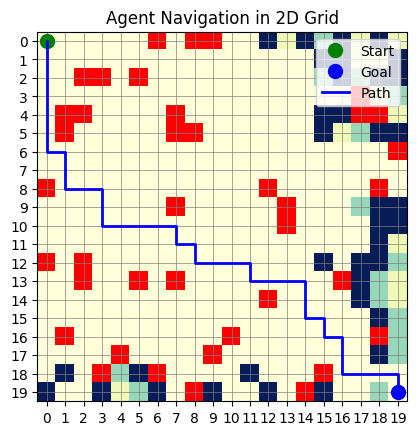

In [ ]:
def run_experiment(size=20, obstacle_density=0.1, terrain_costs=[1, 2, 5]):
    print(f"--- Running Experiment on {size}x{size} Grid ---")

    # 1. Setup Environment
    grid = Grid(size, obstacle_density, terrain_costs)
    pathfinder = Pathfinder(grid)

    # 2. Run Uniform-Cost Search
    start_time = time.time()
    ucs_path, ucs_nodes = pathfinder.uniform_cost_search()
    ucs_time = time.time() - start_time
    ucs_cost = sum(grid.grid[p] for p in ucs_path) if ucs_path else None

    # 3. Run A* Search
    start_time = time.time()
    astar_path, astar_nodes = pathfinder.a_star_search()
    astar_time = time.time() - start_time
    astar_cost = sum(grid.grid[p] for p in astar_path) if astar_path else None

    # 4. Report Results
    print("\n--- Algorithm Comparison ---")

    if ucs_path:
        print(f"Uniform-Cost Search:")
        print(f"  Path Cost: {ucs_cost:.2f}")
        print(f"  Nodes Expanded: {ucs_nodes}")
        print(f"  Execution Time: {ucs_time:.4f}s")
    else:
        print("Uniform-Cost Search: No path found.")

    if astar_path:
        print(f"\nA* Search:")
        print(f"  Path Cost: {astar_cost:.2f}")
        print(f"  Nodes Expanded: {astar_nodes}")
        print(f"  Execution Time: {astar_time:.4f}s")
    else:
        print("A* Search: No path found.")

    # 5. Visualize Results
    if astar_path:
      print("\nA* Path Visualization:")
      grid.display(path=astar_path, expanded_nodes=pathfinder.nodes_explored_list)

run_experiment()


--- Running Dynamic Obstacle Experiment on 20x20 Grid ---
Initial A* path found. Starting dynamic simulation...

Dynamic simulation complete.


/tmp/ipython-input-2584655350.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu', 10)


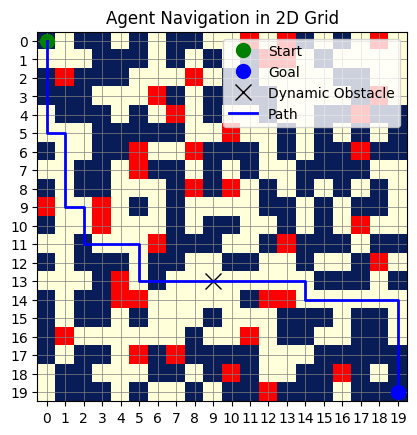

In [ ]:
def run_dynamic_experiment(size=20):
    print(f"\n--- Running Dynamic Obstacle Experiment on {size}x{size} Grid ---")

    grid = Grid(size, obstacle_density=0.1, terrain_costs=[1, 2])
    pathfinder = Pathfinder(grid)

    # Initial plan with A*
    initial_path, _ = pathfinder.a_star_search()

    if not initial_path:
        print("Initial A* plan failed.")
        return

    print("Initial A* path found. Starting dynamic simulation...")

    # Introduce a dynamic obstacle on the path
    obstacle_pos = initial_path[len(initial_path) // 2] # Midpoint of the path
    dynamic_obs = DynamicObstacle(obstacle_pos, size)
    grid.add_dynamic_obstacle(dynamic_obs)

    current_pos = grid.start

    for i in range(len(initial_path) - 1):
        next_pos = initial_path[i+1]

        # Check if next step is blocked by dynamic obstacle
        if next_pos == dynamic_obs.position:
            print(f"\nStep {i}: Collision imminent! Replanning...")

            # Use a local replanning strategy (Simulated Annealing)
            path_segment_to_replan = initial_path[i:]
            replanned_segment = pathfinder.simulated_annealing_replanning(current_pos, grid.goal, path_segment_to_replan)

            # Update the path
            initial_path = initial_path[:i] + replanned_segment

            print("Replanning complete. New path segment found.")

        current_pos = next_pos
        grid.update_dynamic_obstacles()

    print("\nDynamic simulation complete.")
    grid.display(path=initial_path)

run_dynamic_experiment()

4. Analysis

Analysis of Algorithm Performance

Uniform-Cost Search (UCS): This algorithm is optimal and will always find the lowest-cost path. However, it is an uninformed search. It expands nodes level by level based on their cumulative cost, without any "sense" of direction. This often leads to exploring a large number of nodes that are not on the optimal path, making it slow and computationally expensive, especially on large, open grids. Its performance metric (nodes expanded) will be significantly higher than A*.

A* Search: A* is an informed search. By using the Manhattan distance heuristic, it efficiently prunes the search space by prioritizing nodes that are closer to the goal. As a result, it expands far fewer nodes and finds the optimal path much faster than UCS. The path cost found will be the same as UCS (since the heuristic is admissible), but the time and nodes expanded will be much lower. This makes A* the superior choice for static pathfinding.

Simulated Annealing (Local Search): Unlike the other two, this is not a global pathfinding algorithm. Its strength lies in handling dynamic changes. When a pre-computed path (e.g., from A*) is blocked, a global replanning with A* can be computationally expensive and slow for real-time applications. Simulated annealing provides a fast, approximate solution to find a new, short-term path segment to bypass an immediate obstacle. It might not find the new globally optimal path, but it's effective for reactive, real-time navigation.

Conclusion:

For static environments, A* is the best algorithm due to its efficiency and optimality.

For dynamic environments, a hybrid approach is most effective: use A* for the initial global path planning and a local search method like Simulated Annealing for reactive, real-time replanning when unexpected obstacles are encountered.